
# Om å finne illustrasjoner i bøker fra NB digital

Fra en oversikt over alle illustrasjoner i NB-digital (ca. 480 000 bøker) kan vi studere selve illustrasjonene. Hva som kan vises er avhengig av tilgangsnivå, og hvor vi er, på jobb på NB eller på privatmaskin. 

Det frie materialet kan nås fra hvor som helst, mens det som har restriksjoner også er begrenset innad i NB. For begrenset materiale er det kun mulig å få ut deler av en illustrasjon, men det er mulig å mekke det til så man får sett alt. Foreløpig er ikke det gjort. 

### Litt startkode

In [2]:
import dhlab.module_update as mu
mu.update("nbpictures", silent = True)
from nbpictures import show_illustrations_urn, urns_from_super, load_picture, get_urls_from_illustration_data, get_illustration_data_from_book
import nbpictures as nbp
from IPython.display import HTML, Markdown, display
from skimage import data, io, filters, feature, color
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
mu.css()

In [4]:
#!/usr/bin/env python
# coding: utf-8

# In[8]:


import sqlite3
import os
import tarfile
import shutil
import dhlab.nbtokenizer as tok


# In[4]:


def alto_extract(altofile, to_path = '.'):
    """
    Pakk ut tarfil til ramdisk og returnerer mappen filene ligger i
    """


    tf = tarfile.open(altofile, 'r')
    # lag mappe på disk med navnet foran det som står foran .tar
    filename = os.path.basename(altofile)
    dname = filename.split('.tar')[0]
    ndir = os.path.join(to_path, dname )
    os.mkdir(ndir)
    # Pakk ut alt til mappen
    tf.extractall(ndir)
    tf.close()
    return ndir


def process_alto(ndir):
    """Hent ut alle ordene i alto-filen, og legg til paragraf og sidenummer. Mappen ndir peker til mappen der alto-xml-filene ligger"""
    
    import xml.etree.ElementTree as ET
    import shutil
    
    # XML-filene ligger i mappen ndir, så gå gjennom med os.walk()
    # Alle filene blir liggende i variabelen f
    r,d,f = next(os.walk(ndir))
    
    # hent sidene i teksten og legg dem i variabelen pages
    # skip metadatafilene - tekstene har sidenummer representert som 4-sifrede nummer, f.eks. 0014
    pages = []
    
    for page in f:
        pag = page.split('.xml')[0].split('_')[-1]
        try:
            int(pag)
            pages.append((page, int(pag)))
        except:
            True
        
    # Gå gjennom side for side og hent ut teksten. Delte ord blir lagt i variabelen hyph,
    # teksten i text. Alle ord får et sekvensnummer relativt til boka det står i, samtidig
    # som alle avsnitt blir nummerert fortløpende
    
    para_num = 1
    word_num = 1

    text = []
    hyph = []

    hyp1 = ""
    hyp2 = ""
    
    # sorter variabelen pages på sidenummer, andre ledd i tuplet
    for page in sorted(pages, key=lambda x: x[1]):
        page_file = os.path.join(r, page[0])
        page_num = page[1]
        
        # parse XML-fila og få tak i rotelementet root
        tree = ET.parse(page_file)
        root = tree.getroot()
        
        # Gå gjennom XML-strukturen via TextBlock, som er avsnittselementet
        for paragraph in root.findall(".//TextBlock"):
            
            # Finn alle ordene i avsnittet, som attributter til elementet String,
            # og sjekk om det foreligger en orddeling -
            # i så fall ligger hele ordet i attributtet SUBS_CONTENT, mens første ledd av orddelingen
            # ligger i CONTENT. Om det ikke er noen orddeling ligger ordet i attributtet CONTENT.
            # Burde fungere også med orddelinger over sideskift
            
            # Ordet lagres sammen med sekvensnummeret og sekvensnummeret for avsnittet står i,
            # i tillegg til sidenummeret, som kan være greit for oppslag i bokhylla, i forbindelse
            # med generering av konkordanser.
            
            for string in paragraph.findall(".//String"):
                if 'SUBS_TYPE' in string.attrib:
                    if string.attrib['SUBS_TYPE'] == "HypPart1":
                        #tokens = tok.tokenize(string.attrib['SUBS_CONTENT'])
                        tokens = [string.attrib['SUBS_CONTENT']]
                        for token in tokens:
                            text.append((token, word_num, para_num, page_num))
                            word_num += 1
                    elif string.attrib['SUBS_TYPE'] == "HypPart2":
                        hyp2 = string.attrib['CONTENT']
                        hyph.append((hyp1, hyp2))
                else:
                    #tokens = tok.tokenize(string.attrib['CONTENT'])
                    tokens = [string.attrib['CONTENT']]
                    for token in tokens:
                        text.append((token, word_num, para_num, page_num))
                        word_num += 1
            para_num += 1
    # returner teksten som en sekvens av tupler, sammen med orddelingene, også som en sekvens av tupler
    return text #, hyph

Hent ut noen URN-er, eller bruk URN-er funnet annet sted

In [3]:
import imp

In [185]:
imp.reload(nbp)

<module 'nbpictures' from 'C:\\Users\\larsj\\Documents\\GitHub\\illustrations_bokhylla\\nbpictures.py'>

In [194]:
small_scale = 0.59
large_scale = 1.58

In [203]:
def get_urls_from_illustration_data(illus, part = True, scale = None, cuts = True, cutout = None, delta = 0):
    """part sets size of output of page, if part is True it returns a cut out of image
    using position data in illus is a dictionary of with entries and values like this: 
    {'height': 270, 'hpos': 251, 'page': 'digibok_2017081626006_0018', 'resolution': 400, 'vpos': 791, 'width': 373} 
    the variable cuts, if true allows cropping of image - restricted images must not go over 1024 x 1024 pixels
    
    The variable cutout, if different from zero, picks out a part of the picture, specifically made for
    finding the signature part of illustrations.
    """
    
    urn = "URN:NBN:no-nb_" + illus['page']
    
    if scale == None:
        if illus['resolution'] >= 300 or illus['resolution'] < 100:
            scale = large_scale
        else:
            scale = small_scale
            
    height = int(illus['height']) + 2*delta
    width = int(illus['width']) + 2*delta
    vpos = int(illus['vpos']) - delta
    hpos = int(illus['hpos']) - delta
    
    # check cutout, then that value will take precedence
    if cutout != None:
        (widthc, heightc) = cutout
        vpos = vpos + width - widthc
        hpos = hpos + height - heightc
        width = widthc
        height = heightc
        
    if cuts != False:
        if width * scale > 1024:
            width = int(1024/scale)
        if height * scale > 1024:
            height = int(1024/scale)
            

    if part == True:
        # return cut out
        url = "https://www.nb.no/services/image/resolver/{urn}/{hpos},{vpos},{width},{height}/full/0/native.jpg".format(
            urn = urn, 
            width = int(width * scale), 
            height = int(height * scale), 
            vpos = int(vpos * scale), 
            hpos = int(hpos * scale)
        )
    else:
        # return whole page
        url = "https://www.nb.no/services/image/resolver/{urn}/full/0,{part}/0/native.jpg".format( part=part,
                urn = urn, width=illus['width'], height= illus['height'], vpos=illus['vpos'], hpos=illus['hpos'])
    
    return url

In [215]:
urns = nbp.urns_from_super("lillebror og knerten", period=('19200101', '19900101'), conditions = {'digitalAccessibleOnly':'true','profile':'wwwnbno'})

Konverter bøker til illustrasjonsdata

In [216]:
illustrations = get_illustration_data_from_book(urns[0])

In [221]:
books = {u:[get_urls_from_illustration_data(ill, cutout=None) for ill in get_illustration_data_from_book(u)[:20]] for u in urns[:5]}

In [218]:
books

{'URN:NBN:no-nb_digibok_2010071608086': ['https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0005/1185,1625,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0009/1525,791,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0013/1831,1551,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0021/739,1564,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0024/1187,1619,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0025/965,1060,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0026/1877,559,177,118/full/0/native.jpg',
  'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0028/1169,1612,1

In [219]:
pics = [y  for x in books for y in books[x]]
pics

['https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0005/1185,1625,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0009/1525,791,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0013/1831,1551,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0021/739,1564,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0024/1187,1619,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0025/965,1060,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0026/1877,559,177,118/full/0/native.jpg',
 'https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0028/1169,1612,177,118/full/0/native.jpg',
 'https://www.nb.no/

In [209]:
pic0 = io.imread(pics[20])

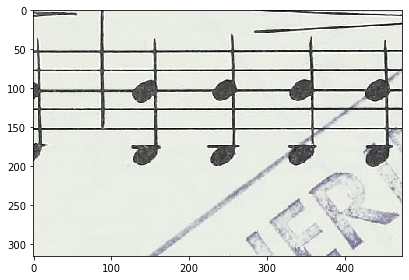

In [210]:
io.imshow(pic0)

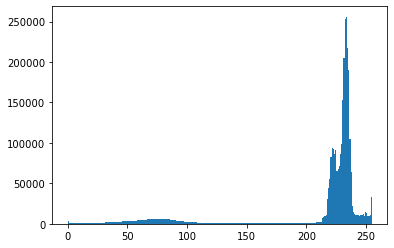

In [183]:
h = plt.hist(pic0.ravel(), bins = 256)
plt.show()

In [211]:
h[1]

array([  0.        ,   0.99609375,   1.9921875 ,   2.98828125,
         3.984375  ,   4.98046875,   5.9765625 ,   6.97265625,
         7.96875   ,   8.96484375,   9.9609375 ,  10.95703125,
        11.953125  ,  12.94921875,  13.9453125 ,  14.94140625,
        15.9375    ,  16.93359375,  17.9296875 ,  18.92578125,
        19.921875  ,  20.91796875,  21.9140625 ,  22.91015625,
        23.90625   ,  24.90234375,  25.8984375 ,  26.89453125,
        27.890625  ,  28.88671875,  29.8828125 ,  30.87890625,
        31.875     ,  32.87109375,  33.8671875 ,  34.86328125,
        35.859375  ,  36.85546875,  37.8515625 ,  38.84765625,
        39.84375   ,  40.83984375,  41.8359375 ,  42.83203125,
        43.828125  ,  44.82421875,  45.8203125 ,  46.81640625,
        47.8125    ,  48.80859375,  49.8046875 ,  50.80078125,
        51.796875  ,  52.79296875,  53.7890625 ,  54.78515625,
        55.78125   ,  56.77734375,  57.7734375 ,  58.76953125,
        59.765625  ,  60.76171875,  61.7578125 ,  62.75

In [212]:
hog0 = feature.hog(pic0, feature_vector = False)

In [213]:
hog0

array([[[[[6.25432404e-03, 0.00000000e+00, 5.23282472e-02, ...,
           9.00800782e-02, 5.13757139e-02, 8.51926842e-02],
          [1.29231123e-02, 1.36650407e-02, 4.17418189e-02, ...,
           0.00000000e+00, 5.97002376e-03, 2.02883383e-02],
          [3.74644021e-02, 0.00000000e+00, 3.83056974e-02, ...,
           1.49607266e-02, 8.87933619e-03, 2.73283376e-03]],

         [[2.77312351e-03, 7.02994301e-03, 1.27230652e-02, ...,
           6.99847955e-03, 7.73543606e-03, 0.00000000e+00],
          [1.12118426e-03, 1.22377603e-02, 6.94946515e-03, ...,
           1.38181563e-02, 2.71927132e-03, 0.00000000e+00],
          [3.62893015e-03, 9.80447209e-04, 2.12876179e-03, ...,
           0.00000000e+00, 9.80447209e-04, 2.77312351e-03]],

         [[2.17541706e-03, 6.08047561e-04, 3.46106693e-03, ...,
           2.69194106e-03, 0.00000000e+00, 0.00000000e+00],
          [1.63156279e-03, 0.00000000e+00, 0.00000000e+00, ...,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
    

In [52]:
corner0 = feature.corner_fast(color.rgb2gray(pic0))

In [32]:
from nbpictures import iiif_manifest

In [40]:
s = "<td>{i}</td>".format(i = 2)
s

'<td>2</td><td>2</td><td>2</td><td>2</td>'

In [103]:
def display_books(books, width = 100):
    """A dictionary of urns - urls is displayed """
    
    html_wrapper = lambda x: """<style>
    img {{
        width:{mxw}px;
        height:auto;
        max-widht:}}
    </style>
    <body>{body}</body>""".format(body = x, mxw = width)

    div_wrapper = lambda x: """<div>{div_content}</div>""".format(div_content = x)
    book_divs = ""
    for u in books:
        mf = iiif_manifest(u)
        thumbnail = "<img src = '{thumbnail}'></img>".format(thumbnail = mf['thumbnail']['@id'])
        metainfo =  '\n'.join(["<b>{label}</b>{val}".format(label = x['label'], val = x['value']) for x in mf['metadata']])        
        imgs = '\n'.join(["<img src='{img_http}'></img>".format(img_http = pic_url) for pic_url in books[u]])
        book_divs += div_wrapper(thumbnail + metainfo + imgs)
    return html_wrapper(book_divs)

In [134]:
def markdown_books(books, width = 100):
    """A dictionary of urns - urls is displayed """
    
    markdown_wrapper = lambda x: """
    <body>{body}</body>""".format(body = x)

    div_wrapper = lambda x: """<div>{div_content}</div>""".format(div_content = x)
    book_divs = ""
    for u in books:
        mf = iiif_manifest(u)
        thumbnail = "<h3>Forside</h3> <img src='{thumbnail}'></img> <h3>Metadata</h3>".format(thumbnail = mf['thumbnail']['@id'])
        metainfo =  '\n'.join([" <b>{label}</b> {val}".format(label = x['label'], val = x['value']) for x in mf['metadata']])        
        imgs = '\n'.join(["<img style='float:right' src='{img_http}' width = {width}></img>".format(img_http = pic_url, width = width) for pic_url in books[u]])
        book_divs += div_wrapper(thumbnail + metainfo + imgs)
    return book_divs

In [104]:
with open('illus.html', 'w') as f:
    f.write(display_books(books, width = 250))

In [222]:
Markdown(markdown_books(books, width = 250))

<div><h3>Forside</h3> <img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_C1/full/0,200/0/native.jpg'></img> <h3>Metadata</h3> <b>Tilgang</b> Tilgang for norske IP-adresser
 <b>Tittel</b> Lillebror og Knerten. 1
 <b>Forfatter</b> Vestly, Anne-Cath.
 <b>Publisert</b> [Stabekk]:Bokklubbens barn, 1990
 <b>Andre opplysninger</b> Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2010-09-08

 <b>Språk</b> Norsk (Bokmål)
 <b>ISBN</b> 8252515746
 <b>Kilde for metadata</b> nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=999003094664702202">999003094664702202</a>)
 <b>Omfang</b> 200 s.
 <b>Medietype</b> bøker
 <b>Dewey</b> 839.823
 <b>Varig lenke</b> <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2010071608086" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2010071608086</a>
 <b></b> <a href="https://www.nb.no/items/6693de15b357426e0ba947aeee9660b0?manifest=https://api.nb.no/catalog/v1/iiif/6693de15b357426e0ba947aeee9660b0/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a><img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0005/672,1361,440,631/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0009/1160,429,538,482/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0013/201,288,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0021/243,431,1023,613/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0024/338,427,1023,966/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0025/615,706,531,467/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0026/1478,405,331,517/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0028/299,343,1023,988/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0030/1257,472,573,394/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0033/231,454,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0038/723,1726,604,533/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0039/1070,483,627,478/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0041/1078,1879,514,758/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0043/951,255,654,427/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0045/202,390,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0048/749,765,521,523/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0049/1196,493,468,441/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0054/366,349,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0057/405,1425,968,1001/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2010071608086_0058/1275,425,545,452/full/0/native.jpg' width = 250></img></div><div><h3>Forside</h3> <img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_C1/full/0,200/0/native.jpg'></img> <h3>Metadata</h3> <b>Tilgang</b> Tilgang for norske IP-adresser
 <b>Tittel</b> Lillebror og Knerten. 2
 <b>Forfatter</b> Vestly, Anne-Cath.
 <b>Publisert</b> [Stabekk]:Bokklubbens barn, 1990
 <b>Andre opplysninger</b> Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2015-11-05

 <b>Språk</b> Norsk (Bokmål)
 <b>ISBN</b> 8252515754
 <b>Kilde for metadata</b> nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=999003096604702202">999003096604702202</a>)
 <b>Omfang</b> 211 s.
 <b>Medietype</b> bøker
 <b>Dewey</b> 839.823
 <b>Varig lenke</b> <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2015010808013" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2015010808013</a>
 <b></b> <a href="https://www.nb.no/items/c871a19b13d399950656aefd61fcc5c7?manifest=https://api.nb.no/catalog/v1/iiif/c871a19b13d399950656aefd61fcc5c7/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a><img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0004/0,102,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0005/935,1385,753,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0008/4,26,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0009/799,336,899,559/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0016/229,270,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0018/206,222,1023,837/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0021/573,1271,699,553/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0022/1254,270,515,616/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0026/132,249,1023,692/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0029/83,172,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0032/175,221,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0034/729,744,543,813/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0035/707,246,984,647/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0040/251,246,1023,938/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0044/124,7,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0046/688,940,562,729/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0047/1216,232,464,655/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0049/303,1937,1023,785/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0052/188,158,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015010808013_0053/0,158,1023,1023/full/0/native.jpg' width = 250></img></div><div><h3>Forside</h3> <img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_C1/full/0,200/0/native.jpg'></img> <h3>Metadata</h3> <b>Tilgang</b> Tilgang for norske IP-adresser
 <b>Tittel</b> Lillebror og Knerten
 <b>Forfatter</b> Vestly, Anne-Cath.
 <b>Illustratør</b> Vestly, Johan
 <b>Publisert</b> Oslo:Tiden, 1962
 <b>Andre opplysninger</b> Opplagshistorikk:  2. oppl. 1965 (Nkr 12.30); 4. oppl. 1973 (Nkr 17.00); 5.  oppl. 1976 (Nkr 21.00); 6. oppl. 1978 (Nkr 23.00); 7.-8  oppl. 1979 (Nkr 29.00); 9. oppl. 1980 (Nkr 35.00); 10.  oppl. 1981 (Nkr 39.00); 11. oppl. 1982 (Nkr 44.00);  [Nytt] 11.-12. oppl. 1989; 13. oppl. 1993 (Nkr 98.00);  14. oppl. 1995
Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2010-12-24

 <b>Språk</b> Norsk (Bokmål)
 <b>ISBN</b> 8210004328
 <b>Kilde for metadata</b> nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=998901948584702202">998901948584702202</a>)
 <b>Omfang</b> 135 s. ill.
 <b>Medietype</b> bøker
 <b>Varig lenke</b> <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2007050804065" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2007050804065</a>
 <b></b> <a href="https://www.nb.no/items/02c16e8137a1e91e6d3e0232150176fb?manifest=https://api.nb.no/catalog/v1/iiif/02c16e8137a1e91e6d3e0232150176fb/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a><img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0001/383,1926,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0005/1180,347,553,492/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0009/180,303,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0014/1519,331,263,613/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0017/235,395,1023,616/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0020/290,344,1023,1006/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0021/668,1246,548,470/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0022/1458,436,341,527/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0024/273,338,1023,1019/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0026/1245,447,581,401/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0029/9,387,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0034/699,2000,619,534/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0035/1034,434,643,488/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0037/1003,1921,546,790/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0039/981,268,671,437/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0041/142,293,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0044/756,925,548,541/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0045/1181,462,480,456/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0050/347,366,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2007050804065_0053/426,1644,987,1023/full/0/native.jpg' width = 250></img></div><div><h3>Forside</h3> <img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_C1/full/0,200/0/native.jpg'></img> <h3>Metadata</h3> <b>Tilgang</b> Tilgang for norske IP-adresser
 <b>Tittel</b> Trofaste Knerten
 <b>Forfatter</b> Vestly, Anne-Cath.
 <b>Medforfatter/Bidragsyter</b> Vestly, Johan
 <b>Publisert</b> [Oslo]:Tiden, 1968
 <b>Andre opplysninger</b> Fortsettelse av: Lillebror og Knerten
Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2017-06-16

 <b>Språk</b> Norsk (Bokmål)
 <b>Kilde for metadata</b> nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=990111803154702202">990111803154702202</a>)
 <b>Omfang</b> 133 s. ill.
 <b>Medietype</b> bøker
 <b>Varig lenke</b> <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2017053048056" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2017053048056</a>
 <b></b> <a href="https://www.nb.no/items/d11803021a46f39716526a0ed120524b?manifest=https://api.nb.no/catalog/v1/iiif/d11803021a46f39716526a0ed120524b/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a><img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0002/718,2207,1023,448/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0003/899,1132,764,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0007/480,221,1023,617/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0010/113,181,1023,935/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0013/83,197,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0015/609,1444,644,578/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0016/1185,301,543,633/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0021/290,158,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0024/872,195,914,652/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0027/237,191,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0032/233,1414,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0035/571,1673,712,595/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0036/1150,206,638,632/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0039/153,165,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0042/248,42,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0047/477,2125,906,554/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0048/1027,183,731,627/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0051/153,180,1023,818/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0054/511,154,853,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2017053048056_0056/205,1610,1023,1023/full/0/native.jpg' width = 250></img></div><div><h3>Forside</h3> <img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_C1/full/0,200/0/native.jpg'></img> <h3>Metadata</h3> <b>Tilgang</b> Tilgang for norske IP-adresser
 <b>Tittel</b> Knerten og forundringspakken
 <b>Forfatter</b> Vestly, Anne-Cath.
 <b>Illustratør</b> Vestly, Johan
 <b>Publisert</b> Oslo:Tiden, 1973
 <b>Andre opplysninger</b> Opplagshistorikk: 2. oppl. 1975 (Nkr 21.00); 3. oppl. 1978 (Nkr 23.00); 4. oppl. 1979 (Nkr 29.00); 5. oppl. 1980 (Nkr 35.00); 6. oppl. 1981 (Nkr 39.00); 8. oppl. 1989 (Nkr 84.00); 9. oppl. 1991 (Nkr 89.00)
Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2010-07-25

 <b>Språk</b> Norsk (Bokmål)
 <b>ISBN</b> 8210007750
 <b>Kilde for metadata</b> nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=999115344904702202">999115344904702202</a>)
 <b>Omfang</b> 142 s. ill.
 <b>Medietype</b> bøker
 <b>Dewey</b> 839.823,  839.93
 <b>Varig lenke</b> <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2008052804024" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2008052804024</a>
 <b></b> <a href="https://www.nb.no/items/0dce2b30cebec852faf4d0f7ef29879d?manifest=https://api.nb.no/catalog/v1/iiif/0dce2b30cebec852faf4d0f7ef29879d/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a><img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0001/22,245,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0005/254,1572,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0009/1160,276,485,811/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0013/155,286,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0018/775,2583,641,431/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0019/964,411,728,646/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0023/237,347,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0029/67,214,1023,995/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0033/480,288,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0036/820,1814,475,768/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0037/860,337,798,834/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0041/640,155,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0046/754,2174,592,634/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0047/1016,289,659,814/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0051/318,223,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0055/188,266,1023,972/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0057/429,2283,1023,490/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0058/977,170,804,867/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0063/88,282,1023,1023/full/0/native.jpg' width = 250></img>
<img style='float:right' src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2008052804024_0067/174,196,1023,1023/full/0/native.jpg' width = 250></img></div>

In [32]:
show_illustrations_urn(urns[0], 'fr')

**Tilgang**: Tilgang for norske IP-adresser
**Tittel**: Christiania skiklub, 1877-1977
**Publisert**: Moestue, 1977
**Emne**: oslo | jubileum | klubber | skiidrett | Christiania skiklub
**Andre opplysninger**: Elektronisk reproduksjon [Norge] Nasjonalbiblioteket Digital 2015-06-03

**Språk**: Norsk (Bokmål)
**Kilde for metadata**: nb.bibsys.no (<a title="Link til post i Oria" href="https://www.oria.no/?vid=NB&search=998520227944702202">998520227944702202</a>)
**Omfang**: 175 s. ill.
**Medietype**: bøker
**Dewey**: 796.93
**UDC**: 796.92(09), 796(09):061.2, 796.92.06, (09), (481.13)
**Varig lenke**: <a href="https://urn.nb.no/URN:NBN:no-nb_digibok_2015051308316" target="_blank">https://urn.nb.no/URN:NBN:no-nb_digibok_2015051308316</a>
****: <a href="https://www.nb.no/items/760e96b4caa3a54840c3d28790caeac4?manifest=https://api.nb.no/catalog/v1/iiif/760e96b4caa3a54840c3d28790caeac4/manifest" target="_blank"><img src="https://www.nb.no/content/uploads/2018/08/logo-iiif.png" alt="IIIF Drag-n-drop"></a>

"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,671,1023,984/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0004/0,1944,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0005/834,1262,366,448/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0006/0,330,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0022/349,368,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0030/342,265,881,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0033/195,281,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0035/1090,451,693,764/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0040/342,2079,1023,815/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0046/380,505,1023,1023/full/0/native.jpg'"
"<img src='https://www.nb.no/services/image/resolver/URN:NBN:no-nb_digibok_2015051308316_0048/366,1796,1023,959/full/0/native.jpg'"
